# Impor Library

In [1]:
import time
import folium
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime
from tqdm import tqdm_notebook

import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import plotly.express as px
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn_pandas import DataFrameMapper
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score

from scipy import stats


# Data & Preprocessing Data

In [3]:
# Load the uploaded Excel file
file_path = '/Users/mac/Documents/SkripsiAcuan/SKRIPSI/data.csv'
df = pd.read_csv(file_path)
df

day  year  month  date   time              address     district  \
0       Monday  2018      1     1   0:15       urip sumuharjo  panakkukang   
1       Monday  2018      1     1   0:30  sungai saddang baru     makassar   
2       Monday  2018      1     1  19:45            boulevard  panakkukang   
3       Monday  2018      1     1  20:10       urip sumuharjo  panakkukang   
4       Monday  2018      1     1  20:30              tinumbu     bontoala   
...        ...   ...    ...   ...    ...                  ...          ...   
3533  Saturday  2020     10    10   7:00          cendrawasih     mamajang   
3534    Sunday  2020     10    11  11:30  metro tanjung bunga     tamalate   
3535    Friday  2020     10     9  14:00          daeng regge        tallo   
3536  Saturday  2020     10    10  18:30  metro tanjung bunga     tamalate   
3537    Sunday  2020     10    11   1:15        g. batu putih     makassar   

     accident_types suspect_vehicle victim_vehicle  
0                 T              R4            NOV  
1                TL              R2             R2  
2                TL              R4             R4  
3                TK              R2             R2  
4                TM              R2            NOV  
...             ...             ...            ...  
3533              T              R2            NOV  
3534             OC              R2            NOV  
3535              T              R2            NOV  
3536             OC              R2            NOV  
3537             TK              R4             R2  

[3538 rows x 10 columns]

Nilai yang hilang pada kolom year, month, dan date:
year     0
month    0
date     0
dtype: int64
Baris dengan nilai datetime yang tidak valid (NaT): 0


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1026/981205005.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_2018, x='accident_types', palette='viridis', alpha=0.7, order=all_accident_types)
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1026/981205005.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_2018, x='suspect_vehicle', palette='Set2', alpha=0.7, order=all_suspect_vehicle)
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1026/981205005.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect

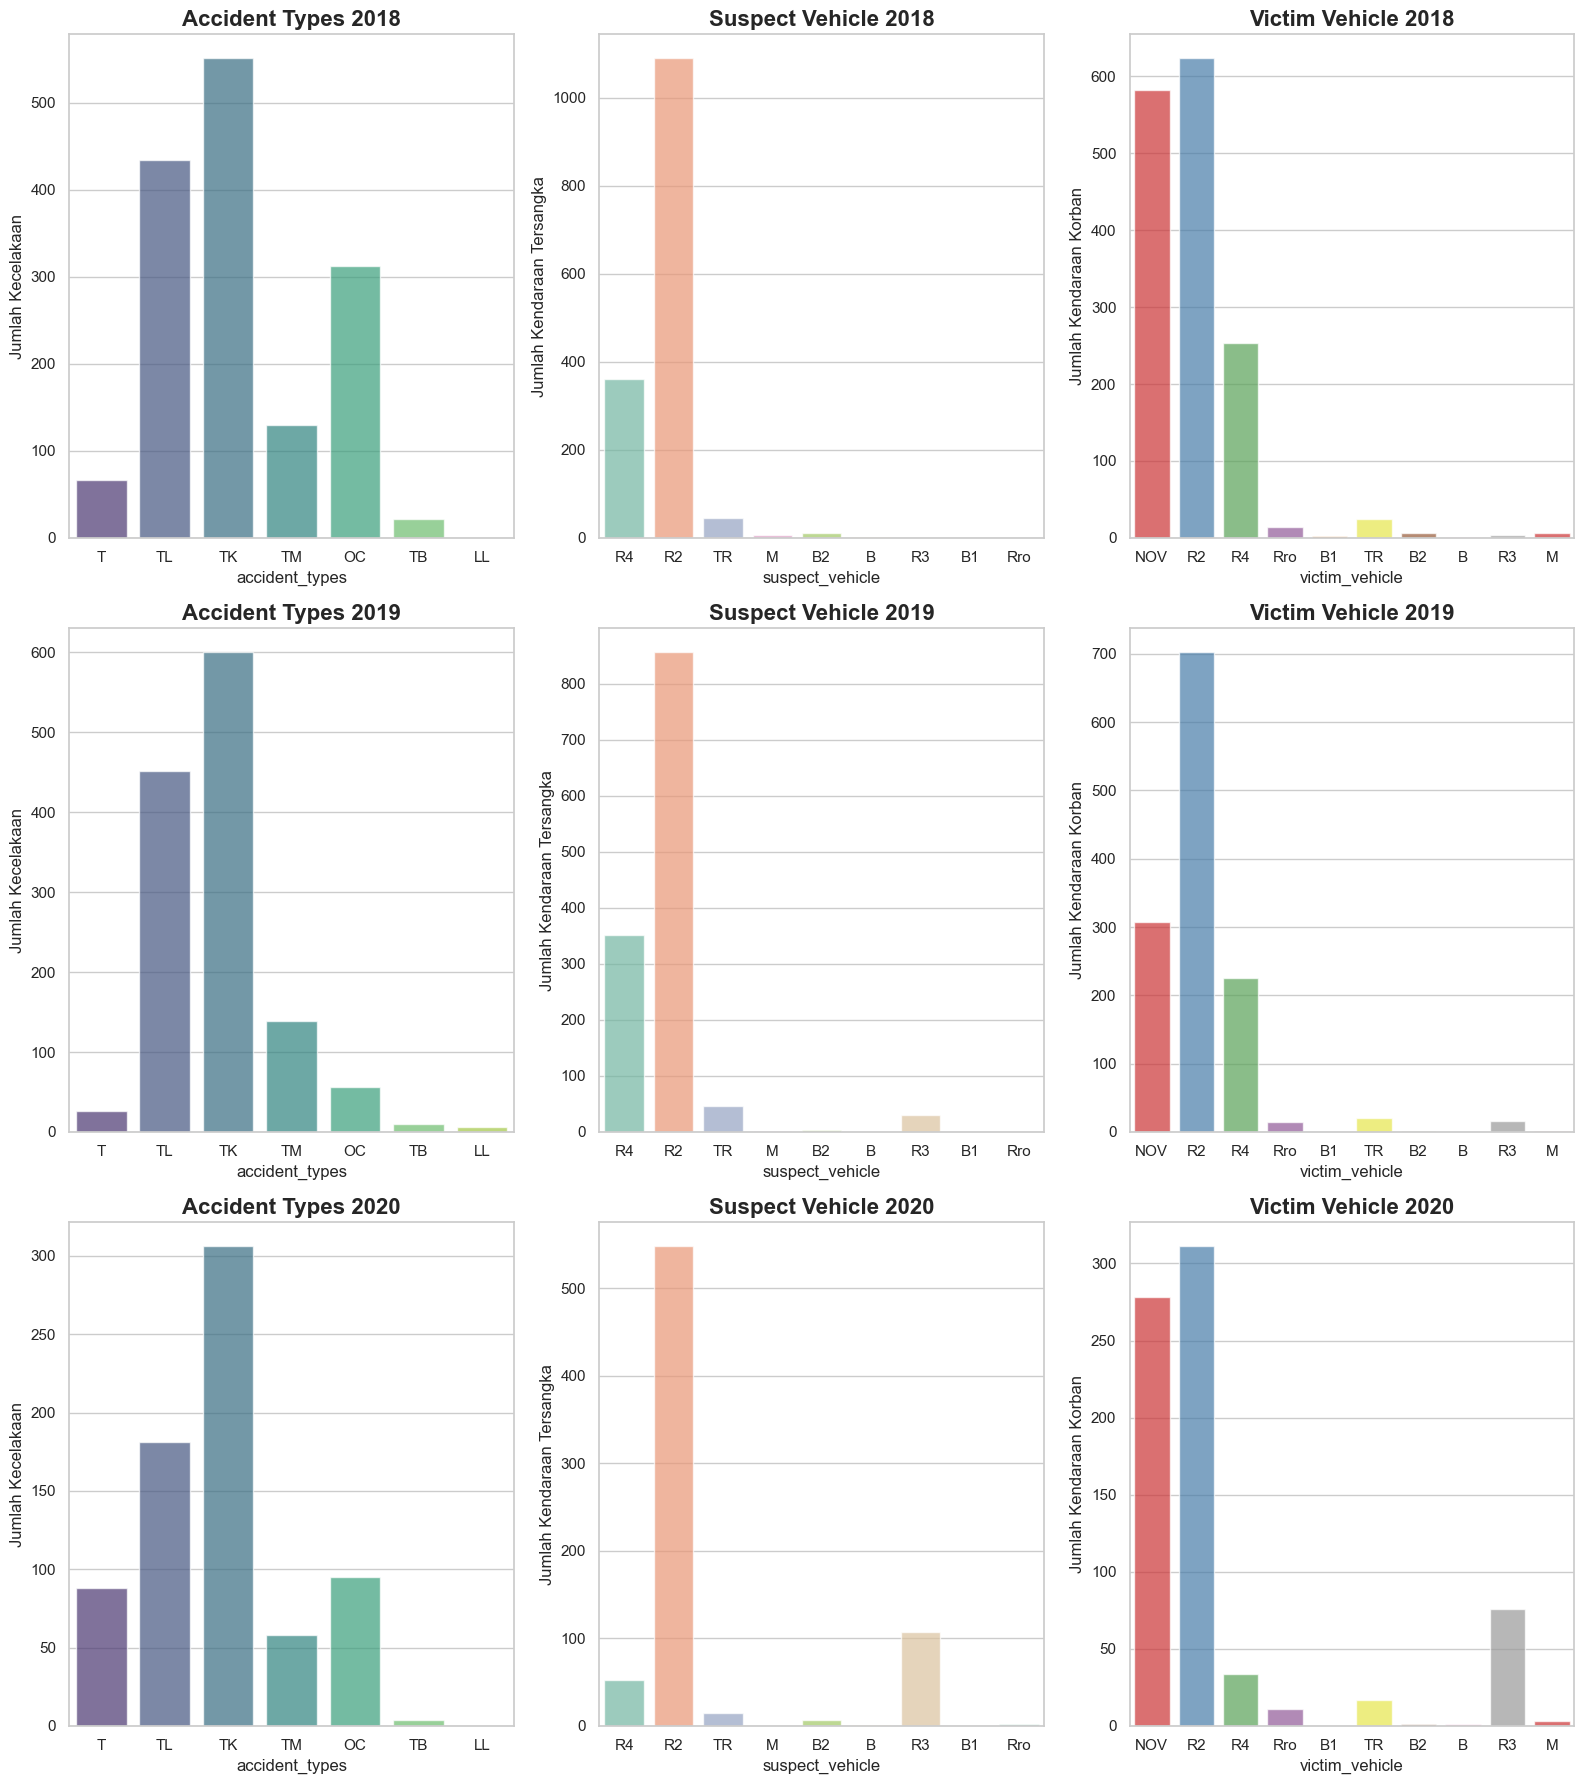

In [7]:
# Mengecek nilai yang hilang pada kolom 'year', 'month', dan 'date'
print("Nilai yang hilang pada kolom year, month, dan date:")
print(df[['year', 'month', 'date']].isna().sum())

# Menghapus baris dengan nilai yang hilang atau tidak valid di 'year', 'month', atau 'date'
df = df[(df['year'].notna()) & (df['month'].notna()) & (df['date'].notna())]
df = df[(df['year'] > 0) & (df['month'] > 0) & (df['month'] <= 12) & (df['date'] > 0) & (df['date'] <= 31)]

# Membuat kolom datetime dengan menggabungkan tahun, bulan, dan tanggal menjadi string
df['datetime_str'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-' + df['date'].astype(str).str.zfill(2)

# Mengonversi string datetime menjadi objek datetime
df['datetime'] = pd.to_datetime(df['datetime_str'], errors='coerce')

# Mengecek ada tidaknya nilai datetime yang tidak valid (NaT artinya Not a Time)
print(f"Baris dengan nilai datetime yang tidak valid (NaT): {df[df['datetime'].isna()].shape[0]}")

# Mengatur gaya visual Seaborn agar lebih menarik dan jelas
sns.set(style="whitegrid")
plt.figure(figsize=(16, 18))

# Menyaring data berdasarkan tahun 2018, 2019, dan 2020
df_2018 = df[df['year'] == 2018]
df_2019 = df[df['year'] == 2019]
df_2020 = df[df['year'] == 2020]

# Pastikan bahwa setiap kategori untuk 'accident_types', 'suspect_vehicle', dan 'victim_vehicle' terdaftar
all_accident_types = df['accident_types'].unique()
all_suspect_vehicle = df['suspect_vehicle'].unique()
all_victim_vehicle = df['victim_vehicle'].unique()

# Konversi kolom menjadi kategori dengan seluruh kemungkinan nilai
df['accident_types'] = pd.Categorical(df['accident_types'], categories=all_accident_types)
df['suspect_vehicle'] = pd.Categorical(df['suspect_vehicle'], categories=all_suspect_vehicle)
df['victim_vehicle'] = pd.Categorical(df['victim_vehicle'], categories=all_victim_vehicle)

# Plot untuk 'accident_types' (Jenis Kecelakaan) untuk 2018
plt.subplot(3, 3, 1)  # 3 baris, 3 kolom, plot ke-1
sns.countplot(data=df_2018, x='accident_types', palette='viridis', alpha=0.7, order=all_accident_types)
plt.title('Accident Types 2018', fontsize=16, fontweight='bold')
plt.xlabel('accident_types', fontsize=12)
plt.ylabel('Jumlah Kecelakaan', fontsize=12)

# Plot untuk 'suspect_vehicle' (Kendaraan Tersangka) untuk 2018
plt.subplot(3, 3, 2)  # 3 baris, 3 kolom, plot ke-2
sns.countplot(data=df_2018, x='suspect_vehicle', palette='Set2', alpha=0.7, order=all_suspect_vehicle)
plt.title('Suspect Vehicle 2018', fontsize=16, fontweight='bold')
plt.xlabel('suspect_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Tersangka', fontsize=12)

# Plot untuk 'victim_vehicle' (Kendaraan Korban) untuk 2018
plt.subplot(3, 3, 3)  # 3 baris, 3 kolom, plot ke-3
sns.countplot(data=df_2018, x='victim_vehicle', palette='Set1', alpha=0.7, order=all_victim_vehicle)
plt.title('Victim Vehicle 2018', fontsize=16, fontweight='bold')
plt.xlabel('victim_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Korban', fontsize=12)

# Plot untuk 'accident_types' (Jenis Kecelakaan) untuk 2019
plt.subplot(3, 3, 4)  # 3 baris, 3 kolom, plot ke-4
sns.countplot(data=df_2019, x='accident_types', palette='viridis', alpha=0.7, order=all_accident_types)
plt.title('Accident Types 2019', fontsize=16, fontweight='bold')
plt.xlabel('accident_types', fontsize=12)
plt.ylabel('Jumlah Kecelakaan', fontsize=12)

# Plot untuk 'suspect_vehicle' (Kendaraan Tersangka) untuk 2019
plt.subplot(3, 3, 5)  # 3 baris, 3 kolom, plot ke-5
sns.countplot(data=df_2019, x='suspect_vehicle', palette='Set2', alpha=0.7, order=all_suspect_vehicle)
plt.title('Suspect Vehicle 2019', fontsize=16, fontweight='bold')
plt.xlabel('suspect_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Tersangka', fontsize=12)

# Plot untuk 'victim_vehicle' (Kendaraan Korban) untuk 2019
plt.subplot(3, 3, 6)  # 3 baris, 3 kolom, plot ke-6
sns.countplot(data=df_2019, x='victim_vehicle', palette='Set1', alpha=0.7, order=all_victim_vehicle)
plt.title('Victim Vehicle 2019', fontsize=16, fontweight='bold')
plt.xlabel('victim_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Korban', fontsize=12)

# Plot untuk 'accident_types' (Jenis Kecelakaan) untuk 2020
plt.subplot(3, 3, 7)  # 3 baris, 3 kolom, plot ke-7
sns.countplot(data=df_2020, x='accident_types', palette='viridis', alpha=0.7, order=all_accident_types)
plt.title('Accident Types 2020', fontsize=16, fontweight='bold')
plt.xlabel('accident_types', fontsize=12)
plt.ylabel('Jumlah Kecelakaan', fontsize=12)

# Plot untuk 'suspect_vehicle' (Kendaraan Tersangka) untuk 2020
plt.subplot(3, 3, 8)  # 3 baris, 3 kolom, plot ke-8
sns.countplot(data=df_2020, x='suspect_vehicle', palette='Set2', alpha=0.7, order=all_suspect_vehicle)
plt.title('Suspect Vehicle 2020', fontsize=16, fontweight='bold')
plt.xlabel('suspect_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Tersangka', fontsize=12)

# Plot untuk 'victim_vehicle' (Kendaraan Korban) untuk 2020
plt.subplot(3, 3, 9)  # 3 baris, 3 kolom, plot ke-9
sns.countplot(data=df_2020, x='victim_vehicle', palette='Set1', alpha=0.7, order=all_victim_vehicle)
plt.title('Victim Vehicle 2020', fontsize=16, fontweight='bold')
plt.xlabel('victim_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Korban', fontsize=12)

# Menampilkan semua plot
plt.tight_layout()
plt.show()


In [4]:
df["address"] = df["address"].map(lambda x: str(x).strip().lower())
df["district"] = df["district"].map(lambda x: str(x).strip().lower())
df.head()

day  year  month  date   time              address     district  \
0  Monday  2018      1     1   0:15       urip sumuharjo  panakkukang   
1  Monday  2018      1     1   0:30  sungai saddang baru     makassar   
2  Monday  2018      1     1  19:45            boulevard  panakkukang   
3  Monday  2018      1     1  20:10       urip sumuharjo  panakkukang   
4  Monday  2018      1     1  20:30              tinumbu     bontoala   

  accident_types suspect_vehicle victim_vehicle  
0              T              R4            NOV  
1             TL              R2             R2  
2             TL              R4             R4  
3             TK              R2             R2  
4             TM              R2            NOV

In [5]:
df.dropna()

day  year  month  date   time              address     district  \
0       Monday  2018      1     1   0:15       urip sumuharjo  panakkukang   
1       Monday  2018      1     1   0:30  sungai saddang baru     makassar   
2       Monday  2018      1     1  19:45            boulevard  panakkukang   
3       Monday  2018      1     1  20:10       urip sumuharjo  panakkukang   
4       Monday  2018      1     1  20:30              tinumbu     bontoala   
...        ...   ...    ...   ...    ...                  ...          ...   
3533  Saturday  2020     10    10   7:00          cendrawasih     mamajang   
3534    Sunday  2020     10    11  11:30  metro tanjung bunga     tamalate   
3535    Friday  2020     10     9  14:00          daeng regge        tallo   
3536  Saturday  2020     10    10  18:30  metro tanjung bunga     tamalate   
3537    Sunday  2020     10    11   1:15        g. batu putih     makassar   

     accident_types suspect_vehicle victim_vehicle  
0                 T              R4            NOV  
1                TL              R2             R2  
2                TL              R4             R4  
3                TK              R2             R2  
4                TM              R2            NOV  
...             ...             ...            ...  
3533              T              R2            NOV  
3534             OC              R2            NOV  
3535              T              R2            NOV  
3536             OC              R2            NOV  
3537             TK              R4             R2  

[3538 rows x 10 columns]

In [6]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [day, year, month, date, time, address, district, accident_types, suspect_vehicle, victim_vehicle]
Index: []

In [7]:
df = df.replace('NaN', np.nan)
print(df.shape)

(3538, 10)


In [8]:
df.replace

<bound method NDFrame.replace of            day  year  month  date   time              address     district  \
0       Monday  2018      1     1   0:15       urip sumuharjo  panakkukang   
1       Monday  2018      1     1   0:30  sungai saddang baru     makassar   
2       Monday  2018      1     1  19:45            boulevard  panakkukang   
3       Monday  2018      1     1  20:10       urip sumuharjo  panakkukang   
4       Monday  2018      1     1  20:30              tinumbu     bontoala   
...        ...   ...    ...   ...    ...                  ...          ...   
3533  Saturday  2020     10    10   7:00          cendrawasih     mamajang   
3534    Sunday  2020     10    11  11:30  metro tanjung bunga     tamalate   
3535    Friday  2020     10     9  14:00          daeng regge        tallo   
3536  Saturday  2020     10    10  18:30  metro tanjung bunga     tamalate   
3537    Sunday  2020     10    11   1:15        g. batu putih     makassar   

     accident_types suspect_ve

In [9]:
df.drop_duplicates

<bound method DataFrame.drop_duplicates of            day  year  month  date   time              address     district  \
0       Monday  2018      1     1   0:15       urip sumuharjo  panakkukang   
1       Monday  2018      1     1   0:30  sungai saddang baru     makassar   
2       Monday  2018      1     1  19:45            boulevard  panakkukang   
3       Monday  2018      1     1  20:10       urip sumuharjo  panakkukang   
4       Monday  2018      1     1  20:30              tinumbu     bontoala   
...        ...   ...    ...   ...    ...                  ...          ...   
3533  Saturday  2020     10    10   7:00          cendrawasih     mamajang   
3534    Sunday  2020     10    11  11:30  metro tanjung bunga     tamalate   
3535    Friday  2020     10     9  14:00          daeng regge        tallo   
3536  Saturday  2020     10    10  18:30  metro tanjung bunga     tamalate   
3537    Sunday  2020     10    11   1:15        g. batu putih     makassar   

     accident_types 

In [6]:
location_df = df[["address", "district"]].copy()
location_df = location_df.drop_duplicates(subset=['address', 'district'])
location_df.reset_index(drop=True, inplace=True)
print(location_df.shape)
location_df.head()

(554, 2)


address     district
0       urip sumuharjo  panakkukang
1  sungai saddang baru     makassar
2            boulevard  panakkukang
3              tinumbu     bontoala
4             kecaping     manggala

In [7]:
# we'll add lat and long column into location_df dataframe
location_df['lat'] = ''
location_df['long'] = ''

start_time = datetime.now().strftime("%H:%M:%S")

locator = Nominatim(user_agent="my_app4")
count = 0
for i in tqdm_notebook(range(len(location_df))):
    try:
        address = "jalan "+ (location_df["address"][i]+', '+ location_df["district"][i]).strip()
        location = locator.geocode(address, timeout=8)
        
        if location != None:
            location_df['lat'][i] = location.latitude
            location_df['long'][i] = location.longitude
            
        else:
            print(f"[{count}]. {address}")
            location_df['lat'][i] = np.nan
            location_df['long'][i] = np.nan 
        count += 1
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(address, e.message))
        
print("start:", start_time)
print("finish: ", datetime.now().strftime("%H:%M:%S"))
location_df.head()

/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(location_df))):


  0%|          | 0/554 [00:00<?, ?it/s]

/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = location.latitude
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413

[18]. jalan dr. leimena, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[20]. jalan pintu bandar udara internasional sultan hasanuddin, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[50]. jalan rutan, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[85]. jalan cendrawasih, mamajang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[93]. jalan ance daeng ngoyo, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[96]. jalan gn. latimojong, makassar


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[115]. jalan kima iii, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[122]. jalan daeng tata raya iii, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[128]. jalan waduk tunggu pampang, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[164]. jalan kw. pergudangan dan industri parangloe, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[166]. jalan dr. leimena, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[168]. jalan toddopuli xii, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[179]. jalan dg. ramang, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[187]. jalan kelapa iii, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[194]. jalan dg. mangga, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[195]. jalan poros hartaco indah, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[197]. jalan masjid baiturrahman, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[206]. jalan anggrek raya, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[211]. jalan paccerakkang, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[218]. jalan lantebung, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[228]. jalan tanjung bayang, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[231]. jalan dr. sutomo, ujung pandang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[235]. jalan bonto bila raya, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[237]. jalan bontoloe, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[246]. jalan monginsidi, mamajang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[252]. jalan btp, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[258]. jalan gunung tinggimae, ujung pandang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[270]. jalan batua raya xii, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[286]. jalan ks. tubun, mariso


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[291]. jalan kima iii, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[295]. jalan perintis kemerdekaan iii, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[307]. jalan insinyur sutami iii, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[308]. jalan kenanga, mariso


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[317]. jalan inpeksi, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[337]. jalan rusunawa, mariso


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[342]. jalan tallasa city, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[343]. jalan tamalate iii, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[346]. jalan professor matulada, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[349]. jalan batua raya iii, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[353]. jalan faisal xii, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[379]. jalan baddoka, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[393]. jalan cendrawasih iii, mariso


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[403]. jalan perintis kemerdekaan vii, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[421]. jalan sultan dg raja, bontoala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[427]. jalan flyover, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[437]. jalan puri kencana sari, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[439]. jalan sunu iii, tallo


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[441]. jalan permata sudiang raya, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[462]. jalan aeng towa, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[470]. jalan perumahan dosen unhas, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[471]. jalan cambaya, tallo


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[474]. jalan pendidikan, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[485]. jalan lorong malioboro, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[489]. jalan andi mangerangi iii, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[490]. jalan ballaparang, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[494]. jalan andi mappaoddang, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[495]. jalan balaikota, ujung pandang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[498]. jalan sungai saddang lama, makassar


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[511]. jalan faisal xvii, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[516]. jalan gn. salahutu, makassar


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[531]. jalan cendrawasih, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[549]. jalan a. tonro, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[551]. jalan indah iii, tallo


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

[552]. jalan hj. saripah, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:21: 

start: 18:46:16
finish:  18:50:57


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413253.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = location.latitude
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1953/2991413

address     district       lat        long
0       urip sumuharjo  panakkukang -5.134824  119.431682
1  sungai saddang baru     makassar -5.146563  119.427809
2            boulevard  panakkukang -5.156057  119.441943
3              tinumbu     bontoala -5.126371  119.418844
4             kecaping     manggala -5.173596   119.50439

In [8]:
location_df.to_excel("datacoordinates.xlsx", index=False)

# Data With Coordinates 

In [2]:
# Load the uploaded Excel file
file_path = '/Users/mac/Documents/SkripsiAcuan/SKRIPSI/datacoordinates.csv'
locdata = pd.read_csv(file_path)

# Display the data
locdata

day  year  month  date       time              address  \
0       Monday  2018      1     1      Night       urip sumuharjo   
1       Monday  2018      1     1      Night  sungai saddang baru   
2       Monday  2018      1     1    Evening            boulevard   
3       Monday  2018      1     1    Evening       urip sumuharjo   
4       Monday  2018      1     1    Evening              tinumbu   
...        ...   ...    ...   ...        ...                  ...   
3533  Saturday  2020     10    10    Morning          cendrawasih   
3534    Sunday  2020     10    11    Morning  metro tanjung bunga   
3535    Friday  2020     10     9  Afternoon          daeng regge   
3536  Saturday  2020     10    10    Evening  metro tanjung bunga   
3537    Sunday  2020     10    11      Night        g. batu putih   

         district accident_types suspect_vehicle victim_vehicle       lat  \
0     panakkukang              T              R4            NOV -5.134824   
1        makassar             TL              R2             R2 -5.146844   
2     panakkukang             TL              R4             R4 -5.155755   
3     panakkukang             TK              R2             R2 -5.134824   
4        bontoala             TM              R2            NOV -5.119549   
...           ...            ...             ...            ...       ...   
3533     mamajang              T              R2            NOV -5.167086   
3534     tamalate             OC              R2            NOV -5.166158   
3535        tallo              T              R2            NOV -5.121902   
3536     tamalate             OC              R2            NOV -5.166158   
3537     makassar             TK              R4             R2 -5.146877   

            long  
0     119.431682  
1     119.425065  
2     119.441102  
3     119.431682  
4     119.420673  
...          ...  
3533  119.411804  
3534  119.391744  
3535  119.438211  
3536  119.391744  
3537  119.418568  

[3538 rows x 12 columns]

In [3]:
# Extract the latitude and longitude columns for calculation
coordinates = locdata[['lat', 'long']]
coordinates

lat        long
0    -5.134824  119.431682
1    -5.146844  119.425065
2    -5.155755  119.441102
3    -5.134824  119.431682
4    -5.119549  119.420673
...        ...         ...
3533 -5.167086  119.411804
3534 -5.166158  119.391744
3535 -5.121902  119.438211
3536 -5.166158  119.391744
3537 -5.146877  119.418568

[3538 rows x 2 columns]

# Outlier Check

In [4]:
# Calculate Z-scores for lat and long
z_scores_lat = stats.zscore(coordinates['lat'])
z_scores_long = stats.zscore(coordinates['long'])

# Identify outliers based on a threshold of 4
outliers_lat = coordinates[np.abs(z_scores_lat) > 4]
outliers_long = coordinates[np.abs(z_scores_long) > 4]

# Remove outliers from the dataset
locdata_clean = coordinates[(np.abs(z_scores_lat) <= 4) & (np.abs(z_scores_long) <= 4)]

# Display results
print("Outliers in Latitude:")
print(outliers_lat)

print("\nOutliers in Longitude:")
print(outliers_long)

print("\nCleaned Data (without outliers):")
print(locdata_clean)

Outliers in Latitude:
Empty DataFrame
Columns: [lat, long]
Index: []

Outliers in Longitude:
Empty DataFrame
Columns: [lat, long]
Index: []

Cleaned Data (without outliers):
           lat        long
0    -5.134824  119.431682
1    -5.146844  119.425065
2    -5.155755  119.441102
3    -5.134824  119.431682
4    -5.119549  119.420673
...        ...         ...
3533 -5.167086  119.411804
3534 -5.166158  119.391744
3535 -5.121902  119.438211
3536 -5.166158  119.391744
3537 -5.146877  119.418568

[3538 rows x 2 columns]


In [5]:
locdata_clean.shape

(3538, 2)

In [6]:
locdata_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3538 entries, 0 to 3537
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     3538 non-null   float64
 1   long    3538 non-null   float64
dtypes: float64(2)
memory usage: 55.4 KB


# Normalization

In [7]:
# Terapkan normalisasi
scaler = MinMaxScaler()
locdata_clean[['lat', 'long']] = scaler.fit_transform(locdata_clean[['lat', 'long']])

# Tampilkan hasil normalisasi
locdata_clean


lat      long
0     0.552591  0.288690
1     0.475941  0.245491
2     0.419113  0.350198
3     0.552591  0.288690
4     0.650007  0.216814
...        ...       ...
3533  0.346850  0.158908
3534  0.352771  0.027932
3535  0.635002  0.331320
3536  0.352771  0.027932
3537  0.475728  0.203071

[3538 rows x 2 columns]

In [8]:
locdata_clean.describe()

lat         long
count  3538.000000  3538.000000
mean      0.510693     0.420304
std       0.162263     0.249462
min       0.000000     0.000000
25%       0.388912     0.221454
50%       0.517853     0.326525
75%       0.577913     0.625676
max       1.000000     1.000000

# Clustering MeanSHift with Bandwidth Scott's Rule

In [9]:
locdata_clean.describe()

lat         long
count  3538.000000  3538.000000
mean      0.510693     0.420304
std       0.162263     0.249462
min       0.000000     0.000000
25%       0.388912     0.221454
50%       0.517853     0.326525
75%       0.577913     0.625676
max       1.000000     1.000000

## Bandwidth Scott's Rule 

Langkah-langkah menentukan Bandwidth Scott's Rule:
1. Menghitung deviasi standar
2. Menghitung rata rata
3. Menyesuaikan dimensi data

In [10]:
# Menghitung standar deviasi untuk latitude dan longitude
lat_std = locdata_clean['lat'].std(ddof=1)
long_std = locdata_clean['long'].std(ddof=1)

# Menampilkan hasil
print(f"Standar deviasi latitude: {lat_std}")
print(f"Standar deviasi longitude: {long_std}")


Standar deviasi latitude: 0.16226347875796404
Standar deviasi longitude: 0.2494616051089353


In [12]:
# Menghitung mean untuk latitude dan longitude
lat_mean = locdata_clean['lat'].mean()
long_mean = locdata_clean['long'].mean()

# Menampilkan hasil
print(f"Mean latitude: {lat_mean}")
print(f"Mean longitude: {long_mean}")


Mean latitude: 0.5106934649670986
Mean longitude: 0.4203036609482663


In [13]:
# Jumlah data
n = len(locdata_clean)

# Standar deviasi untuk latitude dan longitude
lat_std = locdata_clean['lat'].std(ddof=1)
long_std = locdata_clean['long'].std(ddof=1)

# Menghitung bandwidth Scott untuk latitude dan longitude
scott_bandwidth_lat = lat_std * (n ** (-1 / 5))
scott_bandwidth_long = long_std * (n ** (-1 / 5))
# Menghitung rata-rata Scott's Bandwidth untuk latitude dan longitude
scott_bandwidth = (scott_bandwidth_lat + scott_bandwidth_long) / 2
# Menampilkan hasil perhitungan
print(f"Scott's Bandwidth untuk latitude: {scott_bandwidth_lat}")
print(f"Scott's Bandwidth untuk longitude: {scott_bandwidth_long}")
print(f"Scott's Bandwidth: {scott_bandwidth}")

Scott's Bandwidth untuk latitude: 0.03165696068287147
Scott's Bandwidth untuk longitude: 0.04866896904508755
Scott's Bandwidth: 0.04016296486397951


## Gaussian Kernel

In [19]:
# Function to calculate the Gaussian kernel based on the centroid
def gaussian_kernel(xi, centroid, bandwidth):
    distance_squared = np.sum((xi - centroid) ** 2)
    return np.exp(-distance_squared / (2 * bandwidth ** 2))

# Initialize lists to store results
kgaussian_lat = []
kgaussian_long = []
combined_weights = []

# Calculate Gaussian weights for all points with respect to centroid (mean)
centroid = np.array([lat_mean, long_mean])

for index, row in locdata_clean.iterrows():
    point = np.array([row['lat'], row['long']])
    lat_weight = gaussian_kernel(point, centroid, scott_bandwidth_lat)
    long_weight = gaussian_kernel(point, centroid, scott_bandwidth_long)
    combined_weight = lat_weight * long_weight  # Mengalikan bobot latitude dan longitude

    # Append the results
    kgaussian_lat.append(lat_weight)
    kgaussian_long.append(long_weight)
    combined_weights.append(combined_weight)

In [19]:
# Menghitung centroid (rata-rata dari latitude dan longitude)
centroid = np.array([locdata_clean['lat'].mean(), locdata_clean['long'].mean()])

# Function to calculate the Gaussian kernel based on the centroid
def gaussian_kernel(xi, centroid, bandwidth):
    distance_squared = np.sum((xi - centroid) ** 2)
    return np.exp(-distance_squared / (2 * bandwidth ** 2))

# Initialize lists to store distances and Gaussian weights for each point
distance_to_centroid = []
gaussian_weights = []

# Calculate Gaussian weights and distances for all points with respect to the centroid
for index, row in locdata_clean.iterrows():
    point = np.array([row['lat'], row['long']])
    distance = np.sqrt(np.sum((point - centroid) ** 2))  # Euclidean distance to centroid
    weight = gaussian_kernel(point, centroid, scott_bandwidth)
    
    # Store results in lists
    distance_to_centroid.append(distance)
    gaussian_weights.append(weight)

# Menambahkan kolom baru ke dalam DataFrame untuk menampilkan hasil
locdata_clean['Distance_to_Centroid'] = distance_to_centroid
locdata_clean['Gaussian_Weight'] = gaussian_weights

# Menampilkan tabel hasil
print(locdata_clean)

           lat      long  Distance_to_Centroid  Gaussian_Weight
0     0.552591  0.288690              0.138121     2.702894e-03
1     0.475941  0.245491              0.178234     5.291294e-05
2     0.419113  0.350198              0.115333     1.619376e-02
3     0.552591  0.288690              0.138121     2.702894e-03
4     0.650007  0.216814              0.246609     6.502115e-09
...        ...       ...                   ...              ...
3533  0.346850  0.158908              0.308500     1.541967e-13
3534  0.352771  0.027932              0.422960     8.270808e-25
3535  0.635002  0.331320              0.152875     7.142794e-04
3536  0.352771  0.027932              0.422960     8.270808e-25
3537  0.475728  0.203071              0.220029     3.039458e-07

[3538 rows x 4 columns]


In [20]:
kgaussian_lat

[7.350524717620256e-05,
 1.3083453837746119e-07,
 0.0013115901940647097,
 7.350524717620256e-05,
 6.644165713187906e-14,
 1.4225504044253153e-37,
 7.350524717620256e-05,
 0.0013115901940647097,
 7.350524717620256e-05,
 8.285261366856786e-42,
 7.53640312808088e-53,
 7.076633065548404e-10,
 0.011451267546196945,
 1.0197020707990576e-22,
 1.6413101499381252e-14,
 5.545889320089031e-38,
 7.585014528907298e-16,
 6.210757246328868e-14,
 2.7649243883271336e-08,
 5.545889320089031e-38,
 2.2204377234356168e-10,
 1.324821403011984e-21,
 2.9349316685337323e-62,
 8.543590570577858e-05,
 1.9671899818519023e-22,
 7.076633065548404e-10,
 7.57579761956863e-105,
 1.7377405136047265e-49,
 2.360242594559352e-06,
 3.19874267033846e-30,
 8.098253853055383e-20,
 1.3083453837746119e-07,
 4.015199652316227e-20,
 5.545889320089031e-38,
 5.545889320089031e-38,
 0.001882913013402143,
 1.7660682607814e-12,
 3.19874267033846e-30,
 1.9671899818519023e-22,
 1.192834123815363e-17,
 2.9448357856182707e-17,
 1.79127702

In [21]:
kgaussian_long

[0.01782686892812589,
 0.001223896889620702,
 0.06033444886885477,
 0.01782686892812589,
 2.6588180619866363e-06,
 2.572656904536285e-16,
 0.01782686892812589,
 0.06033444886885477,
 0.01782686892812589,
 4.156147552821988e-18,
 8.856850406023922e-23,
 0.0001344747885664802,
 0.15090990449932054,
 4.961070630356048e-10,
 1.4715210738475976e-06,
 1.7270173402207722e-16,
 4.0071946377965594e-07,
 2.584007550010352e-06,
 0.0006340764317065503,
 1.7270173402207722e-16,
 8.23496448665956e-05,
 1.4681332856219941e-09,
 9.250672998943011e-27,
 0.018998192342612737,
 6.551100431294773e-10,
 0.0001344747885664802,
 8.861095101319689e-45,
 2.3445509982777226e-21,
 0.004161468992689169,
 3.3182725101407086e-13,
 8.365764801737038e-09,
 0.001223896889620702,
 6.2172221463793726e-09,
 1.7270173402207722e-16,
 1.7270173402207722e-16,
 0.0703079233386047,
 1.0651495784314238e-05,
 3.3182725101407086e-13,
 6.551100431294773e-10,
 6.915880945705956e-08,
 1.0136845653647189e-07,
 4.826637468433333e-12,


In [22]:
combined_weights

[1.3103684069396587e-06,
 1.601279845751351e-10,
 7.913407150068854e-05,
 1.3103684069396587e-06,
 1.7665627805056323e-19,
 3.6597341199956726e-53,
 1.3103684069396587e-06,
 7.913407150068854e-05,
 1.3103684069396587e-06,
 3.4434768754352388e-59,
 6.67487951049031e-75,
 9.516287352521842e-14,
 0.0017281096917927496,
 5.058813995154448e-32,
 2.4152224743539115e-20,
 9.577847022738946e-54,
 3.039462954784632e-22,
 1.6048643615795297e-19,
 1.753173390088885e-11,
 9.577847022738946e-54,
 1.8285225797331506e-14,
 1.945014399266324e-30,
 2.715009313984776e-88,
 1.6231277695637064e-06,
 1.2887259138548752e-31,
 9.516287352521842e-14,
 6.712986317534895e-149,
 4.0742212559196036e-70,
 9.822076372482978e-09,
 1.0614299869998195e-42,
 6.774808703942208e-28,
 1.601279845751351e-10,
 2.49633882005152e-28,
 9.577847022738946e-54,
 9.577847022738946e-54,
 0.00013238370379953902,
 1.881126863452426e-17,
 1.0614299869998195e-42,
 1.2887259138548752e-31,
 8.249498788282528e-25,
 2.985134583414927e-24,


## Mean Shift CLustering

### MeanShift Manually Iteration

In [24]:
import numpy as np

# Fungsi kernel Gaussian untuk MeanShift
def gaussian_kernel(distance, bandwidth):
    return np.exp(- (distance ** 2) / (2 * (bandwidth ** 2)))

# Fungsi untuk menghitung jarak Euclidean antara dua titik
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Implementasi algoritma MeanShift dengan jarak Euclidean dan bandwidth Scott
def mean_shift_algorithm(data_points, bandwidth, max_iterations=3, tolerance=1e-3):
    centroids = data_points.copy()
    for _ in range(max_iterations):
        updated_centroids = []
        for idx in range(len(centroids)):
            # Menghitung jarak Euclidean antara titik data dan centroid saat ini
            distances = np.array([euclidean_distance(data_points[j], centroids[idx]) for j in range(len(data_points))])
            
            # Menghitung bobot menggunakan kernel Gaussian
            weights = gaussian_kernel(distances, bandwidth)
            
            # Menghitung rata-rata tertimbang dari titik-titik data berdasarkan kernel
            weighted_sum = np.sum(data_points.T * weights, axis=1)
            new_centroid = weighted_sum / np.sum(weights)
            updated_centroids.append(new_centroid)
        
        updated_centroids = np.array(updated_centroids)
        
        # Mengecek pergeseran centroid (konvergensi)
        shift_magnitude = np.linalg.norm(updated_centroids - centroids)
        if shift_magnitude < tolerance:
            break
        
        centroids = updated_centroids
    
    return centroids

# Menggabungkan latitude dan longitude untuk perhitungan MeanShift
data_coordinates = locdata_clean[['lat', 'long']].values

# Menjalankan MeanShift dengan bandwidth Scott
final_centroids_result = mean_shift_algorithm(data_coordinates, scott_bandwidth_lat)

# Menampilkan hasil akhir centroid
print("\nCentroid akhir setelah MeanShift:")
print(final_centroids_result)



Centroid akhir setelah MeanShift:
[[0.55173048 0.2798634 ]
 [0.51235782 0.24167715]
 [0.44323376 0.33965941]
 ...
 [0.59655509 0.28832325]
 [0.35265357 0.0285702 ]
 [0.4754211  0.1966488 ]]


### Meanshift Scott's Rule Bandwidth with Library

In [25]:
# Mengambil nilai latitude dan longitude
mslibrary = locdata[['lat', 'long']].values

# Inisialisasi Bandwidth Scott sebelumnya
bandwidth_latitude = 0.03165696068287147
bandwidth_longitude = 0.04866896904508755
bandwidth = (bandwidth_latitude + bandwidth_longitude) / 2

# Melakukan clustering dengan MeanShift
ms = MeanShift(bandwidth=bandwidth)
ms.fit(mslibrary)

# Mendapatkan label cluster
locdata['cluster'] = ms.labels_

# Menampilkan hasil
locdata

day  year  month  date       time              address  \
0       Monday  2018      1     1      Night       urip sumuharjo   
1       Monday  2018      1     1      Night  sungai saddang baru   
2       Monday  2018      1     1    Evening            boulevard   
3       Monday  2018      1     1    Evening       urip sumuharjo   
4       Monday  2018      1     1    Evening              tinumbu   
...        ...   ...    ...   ...        ...                  ...   
3533  Saturday  2020     10    10    Morning          cendrawasih   
3534    Sunday  2020     10    11    Morning  metro tanjung bunga   
3535    Friday  2020     10     9  Afternoon          daeng regge   
3536  Saturday  2020     10    10    Evening  metro tanjung bunga   
3537    Sunday  2020     10    11      Night        g. batu putih   

         district accident_types suspect_vehicle victim_vehicle       lat  \
0     panakkukang              T              R4            NOV -5.134824   
1        makassar             TL              R2             R2 -5.146844   
2     panakkukang             TL              R4             R4 -5.155755   
3     panakkukang             TK              R2             R2 -5.134824   
4        bontoala             TM              R2            NOV -5.119549   
...           ...            ...             ...            ...       ...   
3533     mamajang              T              R2            NOV -5.167086   
3534     tamalate             OC              R2            NOV -5.166158   
3535        tallo              T              R2            NOV -5.121902   
3536     tamalate             OC              R2            NOV -5.166158   
3537     makassar             TK              R4             R2 -5.146877   

            long  cluster  
0     119.431682        0  
1     119.425065        0  
2     119.441102        0  
3     119.431682        0  
4     119.420673        0  
...          ...      ...  
3533  119.411804        0  
3534  119.391744        0  
3535  119.438211        0  
3536  119.391744        0  
3537  119.418568        0  

[3538 rows x 13 columns]

In [26]:
# Menghitung jumlah cluster
jumlah_cluster = len(np.unique(ms.labels_))
jumlah_cluster


2

In [27]:
print(locdata['cluster'].value_counts())

cluster
0    2352
1    1186
Name: count, dtype: int64


In [28]:
# Menampilkan data untuk cluster 0
print("Data untuk Cluster 0:")
cluster_0_data = locdata[locdata['cluster'] == 0]
cluster_0_data

Data untuk Cluster 0:


day  year  month  date       time              address  \
0       Monday  2018      1     1      Night       urip sumuharjo   
1       Monday  2018      1     1      Night  sungai saddang baru   
2       Monday  2018      1     1    Evening            boulevard   
3       Monday  2018      1     1    Evening       urip sumuharjo   
4       Monday  2018      1     1    Evening              tinumbu   
...        ...   ...    ...   ...        ...                  ...   
3533  Saturday  2020     10    10    Morning          cendrawasih   
3534    Sunday  2020     10    11    Morning  metro tanjung bunga   
3535    Friday  2020     10     9  Afternoon          daeng regge   
3536  Saturday  2020     10    10    Evening  metro tanjung bunga   
3537    Sunday  2020     10    11      Night        g. batu putih   

         district accident_types suspect_vehicle victim_vehicle       lat  \
0     panakkukang              T              R4            NOV -5.134824   
1        makassar             TL              R2             R2 -5.146844   
2     panakkukang             TL              R4             R4 -5.155755   
3     panakkukang             TK              R2             R2 -5.134824   
4        bontoala             TM              R2            NOV -5.119549   
...           ...            ...             ...            ...       ...   
3533     mamajang              T              R2            NOV -5.167086   
3534     tamalate             OC              R2            NOV -5.166158   
3535        tallo              T              R2            NOV -5.121902   
3536     tamalate             OC              R2            NOV -5.166158   
3537     makassar             TK              R4             R2 -5.146877   

            long  cluster  
0     119.431682        0  
1     119.425065        0  
2     119.441102        0  
3     119.431682        0  
4     119.420673        0  
...          ...      ...  
3533  119.411804        0  
3534  119.391744        0  
3535  119.438211        0  
3536  119.391744        0  
3537  119.418568        0  

[2352 rows x 13 columns]

In [29]:
# Menampilkan data untuk cluster 1
print("\nData untuk Cluster 1:")
cluster_1_data = locdata[locdata['cluster'] == 1]
cluster_1_data


Data untuk Cluster 1:


day  year  month  date       time               address  \
5       Tuesday  2018      1     2    Morning              kecaping   
9       Tuesday  2018      1     2    Evening       insinyur sutami   
10    Wednesday  2018      1     3    Morning           batara bira   
11    Wednesday  2018      1     3    Morning  perintis kemerdekaan   
13      Tuesday  2018      1     2    Morning     borong jambu raya   
...         ...   ...    ...   ...        ...                   ...   
3497   Saturday  2020      9    26    Evening       insinyur sutami   
3504     Sunday  2020      9    27  Afternoon           raya baruga   
3518     Sunday  2020     10     4    Morning       insinyur sutami   
3519     Monday  2020     10     5  Afternoon       insinyur sutami   
3529   Thursday  2020     10     8    Morning       insinyur sutami   

          district accident_types suspect_vehicle victim_vehicle       lat  \
5         manggala             OC              R2            NOV -5.171911   
9       tamalanrea             TK              R4             R2 -5.085731   
10    biringkanaya             TK              R2             R2 -5.088497   
11      tamalanrea             OC              R2            NOV -5.140271   
13        manggala             OC              TR            NOV -5.174519   
...            ...            ...             ...            ...       ...   
3497  biringkanaya             TL              R2             R2 -5.076225   
3504      manggala             TK              R2             R2 -5.156699   
3518  biringkanaya             TB              TR             R2 -5.076225   
3519    tamalanrea             TK              R2             R2 -5.085731   
3529    tamalanrea              T              R4            NOV -5.085731   

            long  cluster  
5     119.507523        1  
9     119.490461        1  
10    119.506369        1  
11    119.483294        1  
13    119.488364        1  
...          ...      ...  
3497  119.515201        1  
3504  119.488443        1  
3518  119.515201        1  
3519  119.490461        1  
3529  119.490461        1  

[1186 rows x 13 columns]

# Vizualitation Result

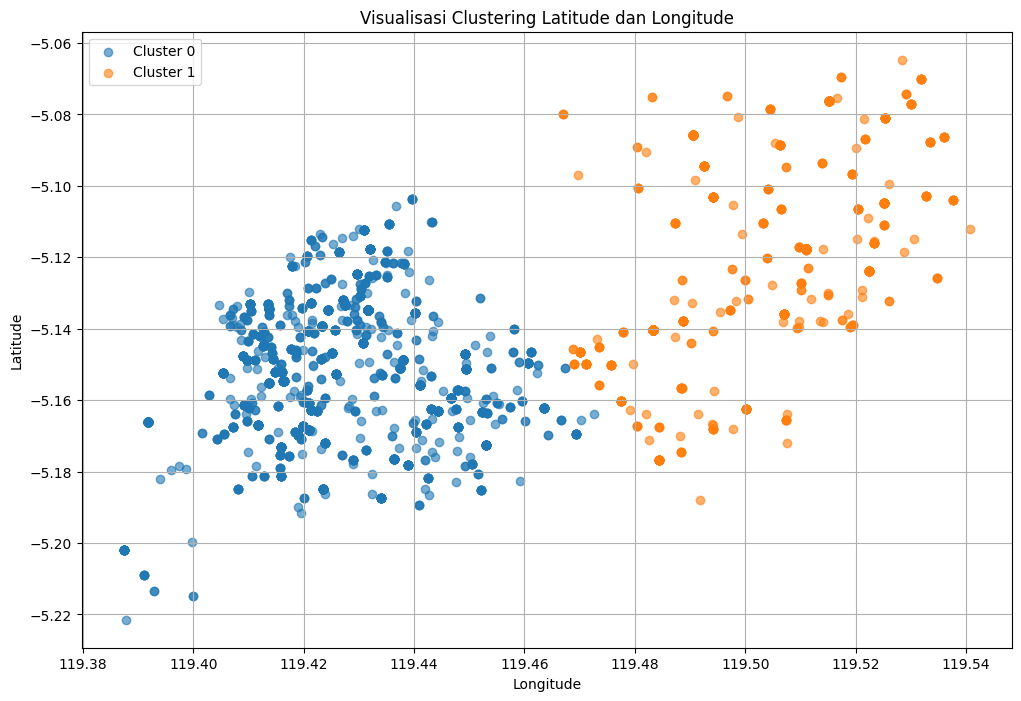

In [30]:
# Visualisasi scatter plot untuk masing-masing cluster
plt.figure(figsize=(12, 8))
for cluster_label in np.unique(locdata['cluster']):
    cluster_data = locdata[locdata['cluster'] == cluster_label]
    plt.scatter(cluster_data['long'], cluster_data['lat'], label=f'Cluster {cluster_label}', alpha=0.6)

plt.title('Visualisasi Clustering Latitude dan Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Menentukan pusat peta
center_lat = locdata['lat'].mean()
center_long = locdata['long'].mean()

# Membuat peta menggunakan Folium
map_clusters = folium.Map(location=[center_lat, center_long], zoom_start=13)

# Warna untuk setiap cluster
colors = itertools.cycle(['blue', 'orange', 'green', 'purple', 'red', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink'])

# Menambahkan data ke peta
for cluster_label in np.unique(locdata['cluster']):
    cluster_data = locdata[locdata['cluster'] == cluster_label]
    color = next(colors)
    for _, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['long']],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=f"Cluster: {cluster_label}\nAddress: {row['address']}"
        ).add_to(map_clusters)
map_clusters

# Evaluation with Silhouette Score

In [32]:
# Menghitung Silhouette Score
silhouette_avg = silhouette_score(mslibrary, locdata['cluster'])

# Menampilkan hasil
print(f'Silhouette Score untuk clustering ini: {silhouette_avg:.4f}')


Silhouette Score untuk clustering ini: 0.5994
